# <center>9. Eclipse dose </center>

### Portpy.photon provides functionalities for importing  the fluence to Eclipse and performing final dose calculation in it. This example demonstrates the comparison between final plan in Eclipse and the portpy generated plan.


1. Creating a simple IMRT plan
    (Plan class, Optimization class)

2. Saving the eclipse fluence and push it to eclipse (Utils class)

3. Export RT DICOM dose and convert it into portpy format (Utils class)

4. Visualize the dose discrepancy between eclipse plan and portpy generated plan (Visualization Class)


In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import os
import matplotlib.pyplot as plt

### 1) Creating a simple IMRT plan (Plan class, Optimization class)


In [4]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Patient_2'

# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params)

# adjust smoothness weight in the objective function to have appropriate MU
for i in range(len(opt_params['objective_functions'])):
    if opt_params['objective_functions'][i]['type'] == 'smoothness-quadratic':
        opt_params['objective_functions'][i]['weight'] = 30

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct, structs, beams, inf_matrix, clinical_criteria)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done


In [6]:
# create cvxpy problem using the clinical criteria and optimization parameters and optimize the plan
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()
sol = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Constraints done


### 2) Saving the eclipse fluence and import it to eclipse

In [4]:
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol, path=os.path.join(r'C:\temp', data.patient_id))

#### 2.a) Importing fluence from portpy to Eclipse manually
To import it to eclipse. Import RT plan in eclipse and right click each field and Select "Import Optimal Fluence" and
select the fluence with correct id from the "path" directory and import the fluence

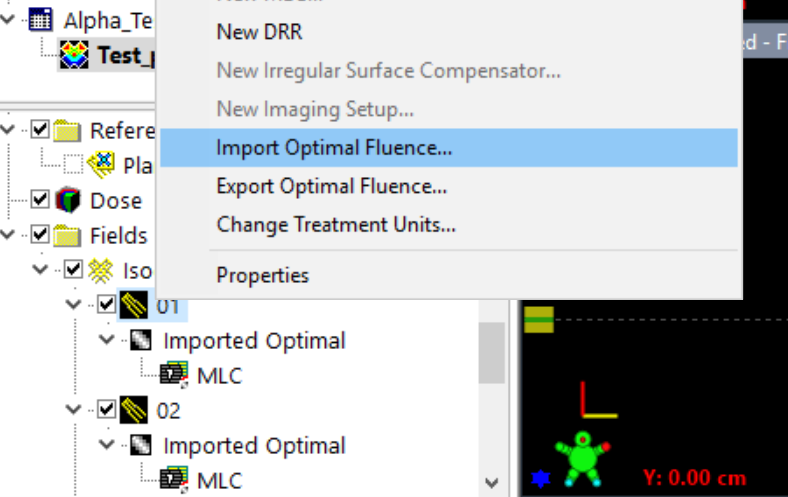

#### 2.b) Run dose calculation in eclipse and normalize the plan properly.
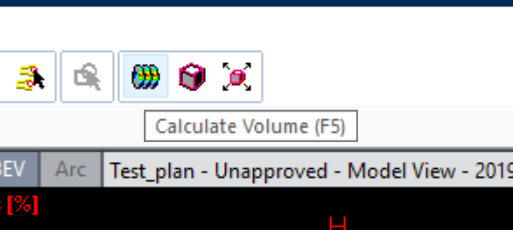

### 3) Export RT DICOM dose from eclipse and convert it into portpy format
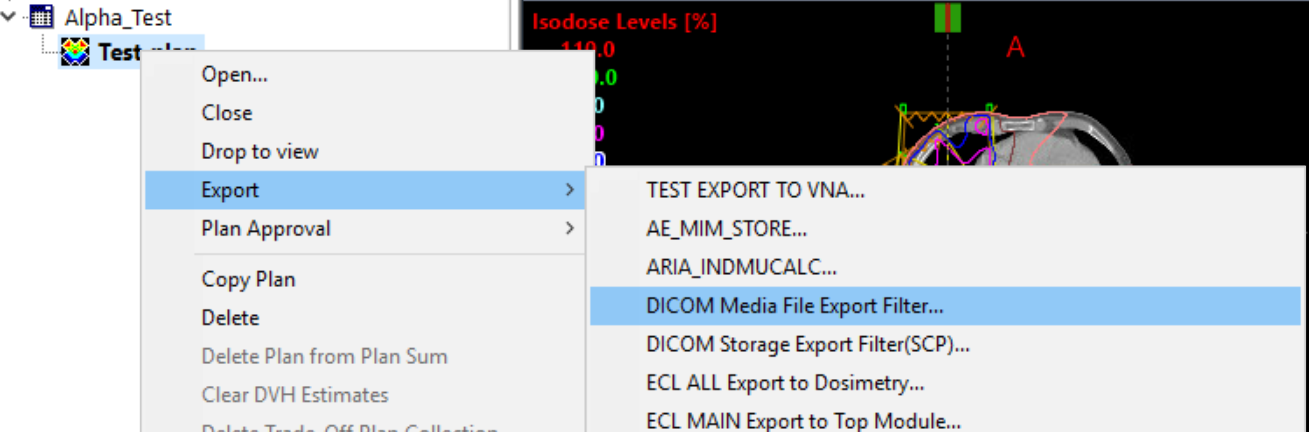

In [5]:
# Export dose in dicom format from eclipse and specify it below
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose.dcm')  # Use need to modify the file name accordingly
ecl_dose_3d = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d)

### 4)  Visualize the dose discrepancy between optimization (with full influence matrix) and Eclipse dose

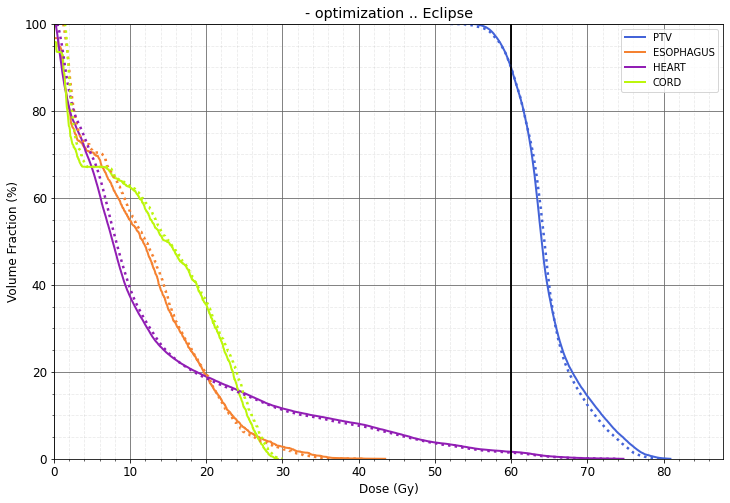

Done!


In [8]:
# load full influence matrix to calculate dose using full matrix
beams_full = pp.Beams(data, load_inf_matrix_full=True)
# load influence matrix based upon beams and structure set
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
dose_full_1d = inf_matrix_full.A @ (sol['optimal_intensity'] * my_plan.get_num_of_fractions()) # calculate dose using full matrix

# Visualize the DVH discrepancy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- optimization .. Eclipse')
plt.show()
print('Done!')